<h1>Проект телекоммуникации</h1>

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
Описание 

**Задача проекта**

Прогнозирование оттока телеком компании, нужно по целевому признаку EndDate предсказать, собирается ли клиент уйти, чтобы при подобном случае компания могла заинтересовать его остаться 

Цель будет достигнута при хорошем показании метрики качества(ROC-AUC не ниже 0,85), так мы узнаем, что модель хорошо предсказывает клиентов, собирающихся уходить

**Описание данных**

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.


Во всех файлах столбец customerID содержит код клиента.


Информация о договорах актуальна на 1 февраля 2020.

**Описание услуг**


Оператор предоставляет два основных типа услуг: 


- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).


Также доступны такие услуги:


- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).


За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

<h1>Предобрабтка данных

**Импорт библиотек**

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
 

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.utils import shuffle

from functools import warning 



RANDOM_STATE = 161023



Скачиваю датасеты

In [2]:
pd.set_option('display.max_columns', None)
df_contract = pd.read_csv('/datasets/contract_new.csv')
df_personal = pd.read_csv('/datasets/personal_new.csv')
df_internet = pd.read_csv('/datasets/internet_new.csv')
df_phone = pd.read_csv('/datasets/phone_new.csv')

Вывод датасетов для знакомста 

In [3]:
df_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


**Описание** customer

- customerID - ID пользователя
- BeginDate - дата начала пользования услугами
- EndDate - дата окончания пользованием услуг
- Type - Тип оплаты(контракт или ежемесячный платеж)
- PaperlessBilling - безбумажный счет?
- PaymentMethod - способ оплаты
- MonthlyCharges - ежемесячный платеж 
- TotalCharges - итоговая сумма?

In [4]:
df_personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


**Описание** personal

- customerID - ID пользователя
- gender - пол пользователя 
- SeniorCitizen - пенсионер ли
- Partner - партнер ли 
- Dependents - подчиненый ли

In [5]:
df_internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


**Описание** internet

- customerID - ID пользователя 
- InternetService - интернет сервис
- OnlineSecurity - подключена ли услуга блокировка небезопасных сайтов
- OnlineBackup -  подключена ли услуга облачного хранения
- DeviceProtection - подключена ли услуга антивируса
- TechSupport - Выделена ли линиия тех под
- StreamingTV - Подключено ли стриминговое подключение
- StreamingMovies - Подключен ли каталог фильмов

In [6]:
df_phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


**Описание** phone

- customerID - ID пользователя
- MultipleLines - ?


Теперь изучу подробнее каждый датасет отдельно

**Contract**

In [7]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропусков нет, над типами признаков надо поработать, так же как и с их названиями

Создам целевой признак - наличие активного клиента

In [8]:
df_contract['target'] = (df_contract['EndDate'] != 'No').astype(int)

In [9]:
df_contract = df_contract.rename(columns={
    'customerID': 'customer_id',
    'BeginDate': 'begin_date',
    'EndDate': 'end_date',
    'Type': 'type',
    'PaperlessBilling': 'paperless_billing',
    'PaymentMethod': 'payment_method',
    'MonthlyCharges': 'monthly_charges',
    'TotalCharges': 'total_charges'
})

begin_date - я просто переведу в тип date, с end_date немного сложнее, я тоже переведу его в тип date, но  значения No, которые отвечают за то, что пользователь не окончил использование услуг заменю на крайнюю дату

In [10]:
df_contract['end_date'] = df_contract['end_date'].replace(['No'], ['2020-02-01'])
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format='%Y-%m-%d')


In [11]:
df_contract['total_days'] = (df_contract['end_date'] - df_contract['begin_date']).dt.days

In [12]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   target             7043 non-null   int64         
 9   total_days         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(5)
memory usage: 550.4+ KB


total_charges - float, тк хранит дробное значение суммы

In [13]:
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'], errors ='coerce')


In [14]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   target             7043 non-null   int64         
 9   total_days         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


Видно, что в total_charges теперь есть немного пропусков

In [15]:
df_contract[df_contract['total_charges'].isnull()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,total_days
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


Тут пропуска, это новые клиенты. заменю на 0

In [16]:
df_contract['total_charges'] = df_contract['total_charges'].fillna(0)


Теперь проверю дубликаты, буду проверять только явные, ведь тут указан ID пользователя и нет смысла искать какие-то другие повторы как мне кажется

In [17]:
df_contract.duplicated().sum()

0

Все отично. Еще не мешало бы посмотреть на графики чтобы увидеть распределение, выбросы и понять какие столбцы важны, а какие нет. Но это я буду делать в исследоватльеском анализе для всех датасетов. Сейчас моя задача была изучить данные

In [18]:
df_contract.describe()

,monthly_charges,total_charges,target,total_days
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.156325,898.555729
std,30.090047,2112.742814,0.363189,683.130510
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,276.000000
50%,70.350000,1343.350000,0.000000,761.000000
75%,89.850000,3236.690000,0.000000,1461.000000
max,118.750000,9221.380000,1.000000,2314.000000


Но все же если говорить предварительно, total_charges имеет явны выброс в положительнй стороне, и, возможно в отрицательной. monthly_charges выглядит хорошо

**df_personal**

In [19]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Такая же ситуация, у нас есть не правильно подписанные признаки, не подходящие лучших образом типы данных и нет пропусков

In [20]:
df_personal = df_personal.rename(columns={
    'customerID': 'customer_id',
    'SeniorCitizen': 'senior_citizen',
    'Dependents' : 'dependents',
    'Partner' : 'partner'
})

In [21]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [22]:
df_personal.duplicated().sum()

0

**internet**

In [23]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


имеем такое дело, как и с первыми 2 датасетами

In [24]:
df_internet = df_internet.rename(columns={
    'customerID': 'customer_id',
    'InternetService': 'internet_service',
    'OnlineSecurity' : 'online_security',
    'OnlineBackup' : 'online_backup',
    'DeviceProtection' : 'device_protection',
    'TechSupport' : 'tech_support',
    'StreamingTV' : 'streamingTV',
    'StreamingMovies' : 'streaming_movies'
})

In [25]:
df_internet.duplicated().sum()

0

**phone**

In [26]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [27]:
df_phone = df_phone.rename(columns={
    'customerID': 'customer_id',
    'MultipleLines': 'multipleLines'
})

In [28]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_id    6361 non-null   object
 1   multipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [29]:
df_phone.duplicated().sum()

0

**Вывод предобработки**

- Все датасеты имели общие проблемы:
    - Не верное название признаков
    - Не верный тип некоторых признаков
- Так же все датасеты:
    - Не имели пропусков
    - Не имели дубликатов
- Метод решения проблем:
    - Название признаков я изменил с помощью rename
    - Тип признаков я изменил с to_numeric, astype или replace
    
Теперь датасет настроен, можно искать выбросы, смотреть распреления и решать, что оставить в нем. После подготовить нужные данные для обучения и начать обучать модель

<h1> Исследовательский анализ данных

- Тут я буду заниматься поиском аномалии и их обработкой. Посмотрю на распределения. Это все для нужно для понимания какие признаки важны, а какие нет

Для удобства составлю один единный датасет

In [30]:
df = df_contract \
    .merge(df_personal, how='left', on='customer_id') \
    .merge(df_internet, how='left', on='customer_id') \
    .merge(df_phone, how='left', on='customer_id') 

In [31]:
df.head(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,total_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streamingTV,streaming_movies,multipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,0,337,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0,671,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,0,306,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,0,945,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1,882,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [32]:
len(df['customer_id'].unique())

7043

In [33]:
df.shape

(7043, 22)

Пользователи уникаьлны

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   target             7043 non-null   int64         
 9   total_days         7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   int64         
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  internet

In [35]:
df[df['internet_service'].isnull()].shape

(1526, 22)

In [36]:
df = df.set_index('customer_id')

In [37]:
list_null2 = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streamingTV', 'streaming_movies']


In [38]:
mask = df[list_null2].isnull().all(axis=1)
filtered_df = df[mask]


In [39]:
filtered_df.shape

(1526, 21)

Тк изначально в датафрейме internet не было пропусков, а просто было меньше строк. И исходя из вывода этой таблицы, можно сказать, что пропуски в местах сервисах это отсутвие услуги, то есть 0

Так же я проверил, получается, что если у пользователя не было ни одной услуги, его нет в таблице internet. Если посчитать кол-во строк по одной услуге и отстувием всех, можно увидеть одинаковое кол-во записей

In [40]:
list_null = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streamingTV', 'streaming_movies', 'multipleLines']

for i in list_null:
    df[i] = df[i].fillna('No')

In [41]:
df[df['internet_service'].isnull()].shape

(0, 21)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   target             7043 non-null   int64         
 8   total_days         7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14

**Графики**

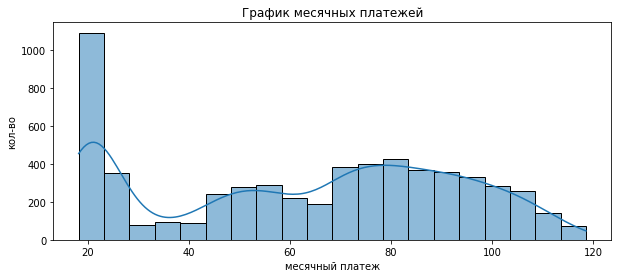

In [43]:
plt.figure(figsize=(10, 4))

sns.histplot(df[df['target'] == 0]['monthly_charges'],kde=True,bins=20)
plt.title('График месячных платежей')
plt.xlabel('месячный платеж')
plt.ylabel('кол-во')
plt.show()

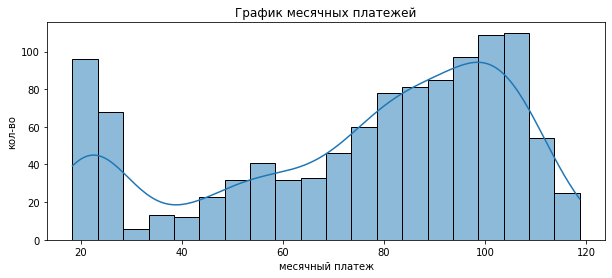

In [44]:
plt.figure(figsize=(10, 4))

sns.histplot(df[df['target'] == 1]['monthly_charges'],kde=True,bins=20)
plt.title('График месячных платежей')
plt.xlabel('месячный платеж')
plt.ylabel('кол-во')
plt.show()

Клиенты, которые ушли, имели повышенные показатели от 85, в отличии от тех кто все еще пользуется услугами

Виден пик до 20, нужно рассмотреть ближе

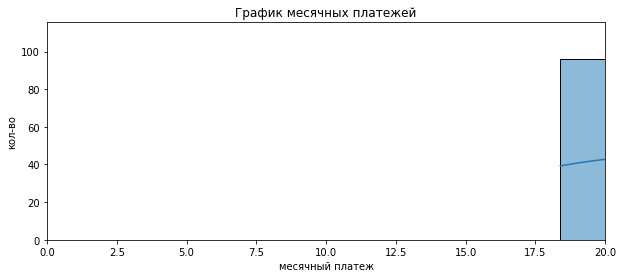

In [45]:
plt.figure(figsize=(10, 4))
plt.xlim(0,20)
sns.histplot(df[df['target'] == 1]['monthly_charges'], kde=True,bins=20)
plt.title('График месячных платежей')
plt.xlabel('месячный платеж')
plt.ylabel('кол-во')
plt.show()

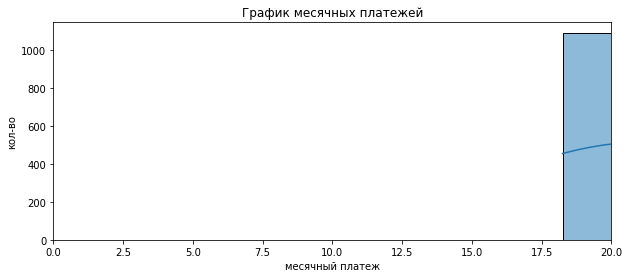

In [46]:
plt.figure(figsize=(10, 4))
plt.xlim(0,20)
sns.histplot(df[df['target'] == 0]['monthly_charges'], kde=True,bins=20)
plt.title('График месячных платежей')
plt.xlabel('месячный платеж')
plt.ylabel('кол-во')
plt.show()

Окей, это не 0 значения. +-20 долларов это минимальный платеж

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно! Скорее всего это какой-то базовый тариф и многие пользуются именно им
</div>

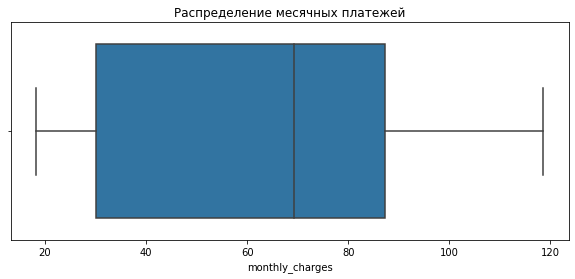

In [47]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df[df['target'] == 0]['monthly_charges'])
plt.title('Распределение месячных платежей')
plt.show()


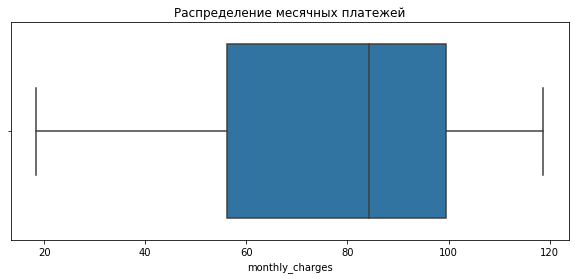

In [48]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df[df['target'] == 1]['monthly_charges'])
plt.title('Распределение месячных платежей')
plt.show()


Выбросов нет, все в порядке

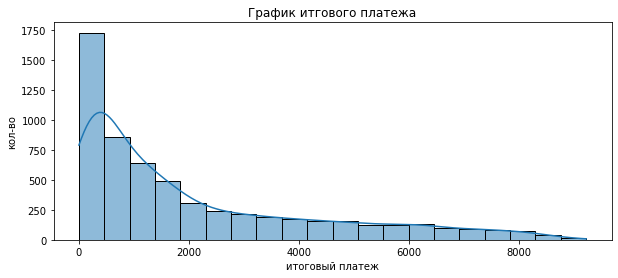

In [49]:
plt.figure(figsize=(10, 4))

sns.histplot(df[df['target'] == 0]['total_charges'], kde=True,bins=20)
plt.title('График итгового платежа')
plt.xlabel('итоговый платеж')
plt.ylabel('кол-во')
plt.show()

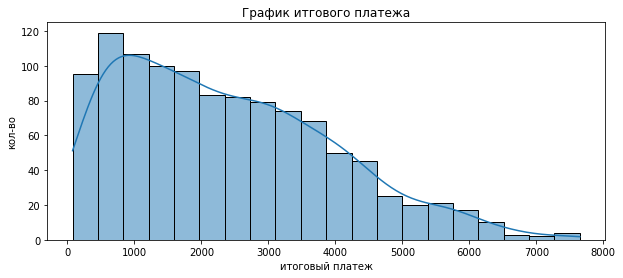

In [50]:
plt.figure(figsize=(10, 4))

sns.histplot(df[df['target'] == 1]['total_charges'], kde=True,bins=20)
plt.title('График итгового платежа')
plt.xlabel('итоговый платеж')
plt.ylabel('кол-во')
plt.show()

Среди актуальных клиентов мало тех, кто в общей сумме платит больше 2000, в отличи от ушедших

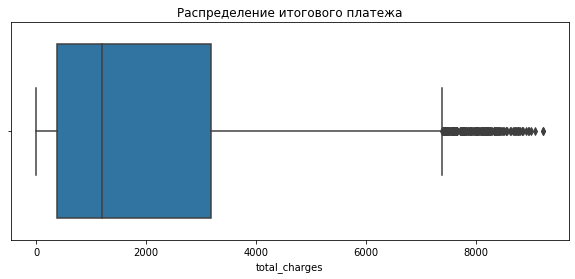

In [51]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df[df['target'] == 0]['total_charges'])
plt.title('Распределение итогового платежа')
plt.show()


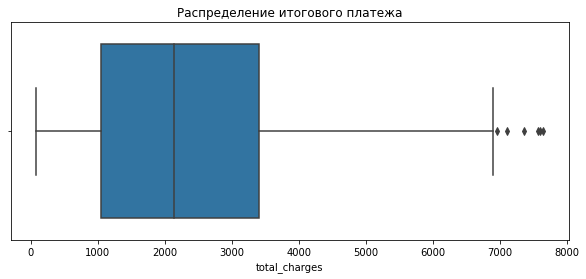

In [52]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df[df['target'] == 1]['total_charges'])
plt.title('Распределение итогового платежа')
plt.show()


In [53]:
df['total_charges'].describe()

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64

Теперь можно разобраться с услугами и сервисами

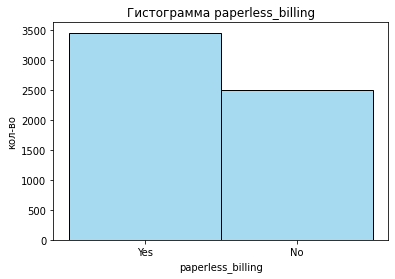

In [54]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 0], x='paperless_billing', color='skyblue')  
plt.title('Гистограмма paperless_billing')  
plt.xlabel('paperless_billing')  
plt.ylabel('кол-во')  
plt.show()  

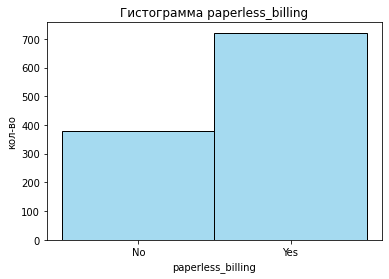

In [55]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 1], x='paperless_billing', color='skyblue')  
plt.title('Гистограмма paperless_billing')  
plt.xlabel('paperless_billing')  
plt.ylabel('кол-во')  
plt.show()  

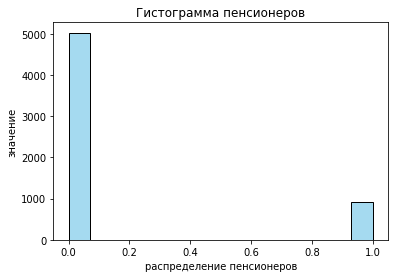

In [56]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 0], x='senior_citizen', color='skyblue')  
plt.title('Гистограмма пенсионеров')  
plt.xlabel('распределение пенсионеров')  
plt.ylabel('значение')  
plt.show()  

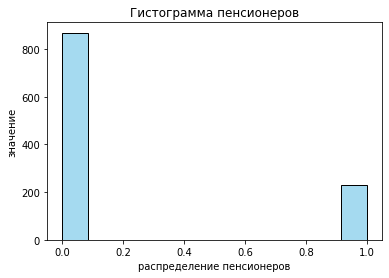

In [57]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 1], x='senior_citizen', color='skyblue')  
plt.title('Гистограмма пенсионеров')  
plt.xlabel('распределение пенсионеров')  
plt.ylabel('значение')  
plt.show()  

Ожидаемый результат, пенсионеров меньше

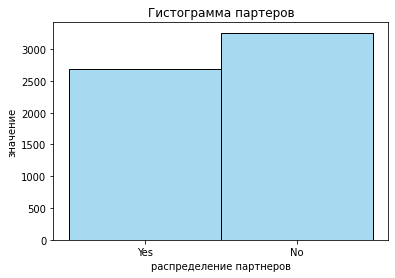

In [58]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 0], x='partner', color='skyblue')  
plt.title('Гистограмма партеров')  
plt.xlabel('распределение партнеров')  
plt.ylabel('значение')  
plt.show()  

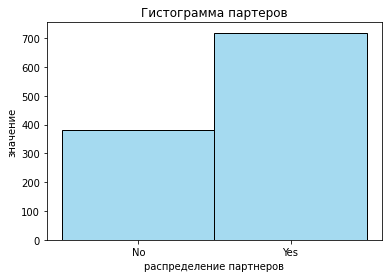

In [59]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 1], x='partner', color='skyblue')  
plt.title('Гистограмма партеров')  
plt.xlabel('распределение партнеров')  
plt.ylabel('значение')  
plt.show()  

парнтеров среди ушедших клиентов намного больше, среди актуальных значения примерно равны. стоит об этом помнить

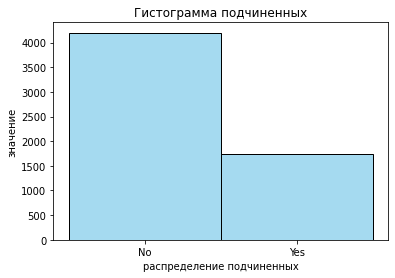

In [60]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 0], x='dependents', color='skyblue')  
plt.title('Гистограмма подчиненных')  
plt.xlabel('распределение подчиненных')  
plt.ylabel('значение')  
plt.show()  

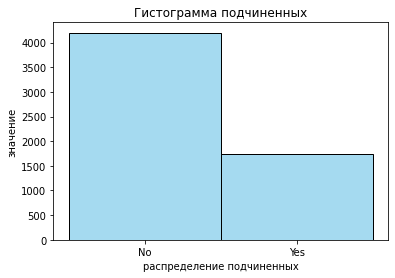

In [61]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 0], x='dependents', color='skyblue')  
plt.title('Гистограмма подчиненных')  
plt.xlabel('распределение подчиненных')  
plt.ylabel('значение')  
plt.show()  

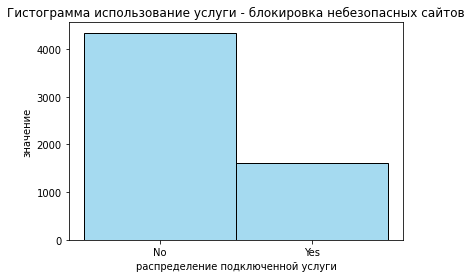

In [62]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 0], x='online_security', color='skyblue')  
plt.title('Гистограмма использование услуги - блокировка небезопасных сайтов')  
plt.xlabel('распределение подключенной услуги')  
plt.ylabel('значение')  
plt.show()  

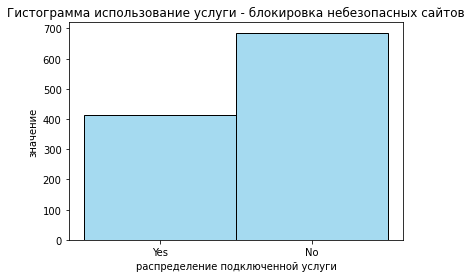

In [63]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 1], x='online_security', color='skyblue')  
plt.title('Гистограмма использование услуги - блокировка небезопасных сайтов')  
plt.xlabel('распределение подключенной услуги')  
plt.ylabel('значение')  
plt.show()  

Среди ушедших эта услуга была более желанной

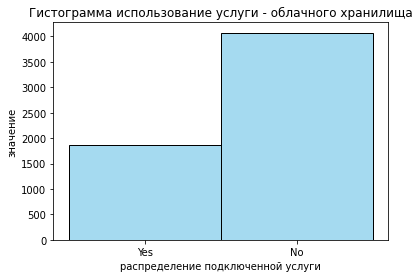

In [64]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 0], x='online_backup', color='skyblue')  
plt.title('Гистограмма использование услуги - облачного хранилища')  
plt.xlabel('распределение подключенной услуги')  
plt.ylabel('значение')  
plt.show()  

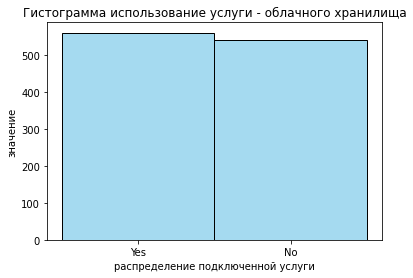

In [65]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 1], x='online_backup', color='skyblue')  
plt.title('Гистограмма использование услуги - облачного хранилища')  
plt.xlabel('распределение подключенной услуги')  
plt.ylabel('значение')  
plt.show()  

Эта улсуга явно популярнее, практический каждый второй пользователей преподчитает её

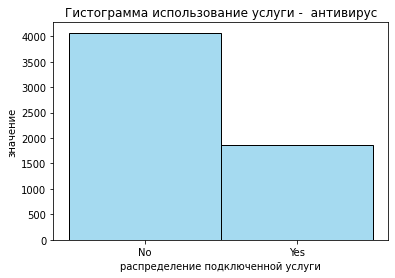

In [66]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 0], x='device_protection', color='skyblue')  
plt.title('Гистограмма использование услуги -  антивирус')  
plt.xlabel('распределение подключенной услуги')  
plt.ylabel('значение')  
plt.show()  

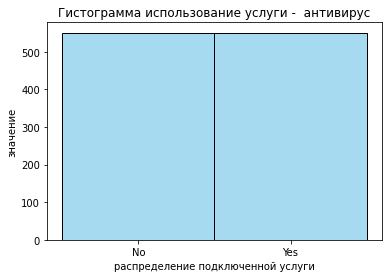

In [67]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 1], x='device_protection', color='skyblue')  
plt.title('Гистограмма использование услуги -  антивирус')  
plt.xlabel('распределение подключенной услуги')  
plt.ylabel('значение')  
plt.show()  

Половина покинувших сервис клиентов пользовались антивирусом

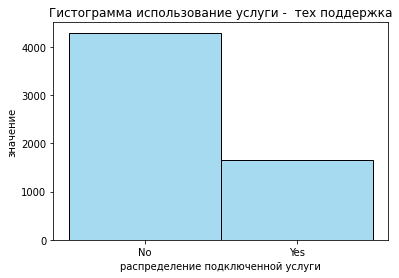

In [68]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 0], x='tech_support', color='skyblue')  
plt.title('Гистограмма использование услуги -  тех поддержка')  
plt.xlabel('распределение подключенной услуги')  
plt.ylabel('значение')  
plt.show()  

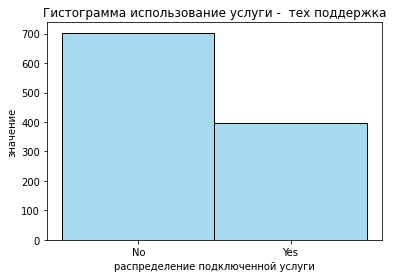

In [69]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 1], x='tech_support', color='skyblue')  
plt.title('Гистограмма использование услуги -  тех поддержка')  
plt.xlabel('распределение подключенной услуги')  
plt.ylabel('значение')  
plt.show()  

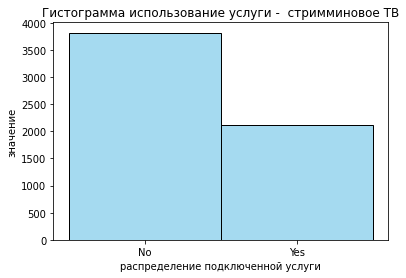

In [70]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 0], x='streamingTV', color='skyblue')  
plt.title('Гистограмма использование услуги -  стримминовое ТВ')  
plt.xlabel('распределение подключенной услуги')  
plt.ylabel('значение')  
plt.show()  

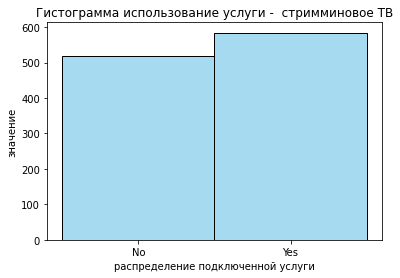

In [71]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 1], x='streamingTV', color='skyblue')  
plt.title('Гистограмма использование услуги -  стримминовое ТВ')  
plt.xlabel('распределение подключенной услуги')  
plt.ylabel('значение')  
plt.show()  

Стримминговое ТВ пользовалось большим спросом у бывших

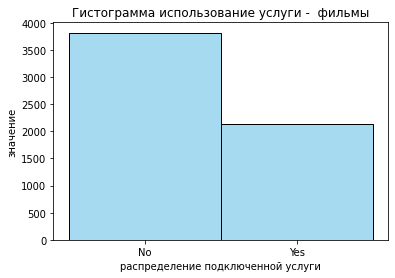

In [72]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 0], x='streaming_movies', color='skyblue')  
plt.title('Гистограмма использование услуги -  фильмы')  
plt.xlabel('распределение подключенной услуги')  
plt.ylabel('значение')  
plt.show()  

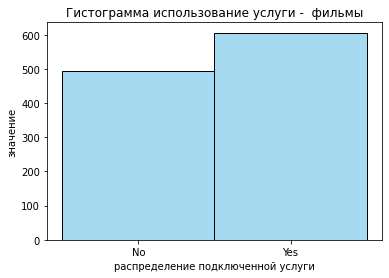

In [73]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 1], x='streaming_movies', color='skyblue')  
plt.title('Гистограмма использование услуги -  фильмы')  
plt.xlabel('распределение подключенной услуги')  
plt.ylabel('значение')  
plt.show()  

тоже касается и фильмов

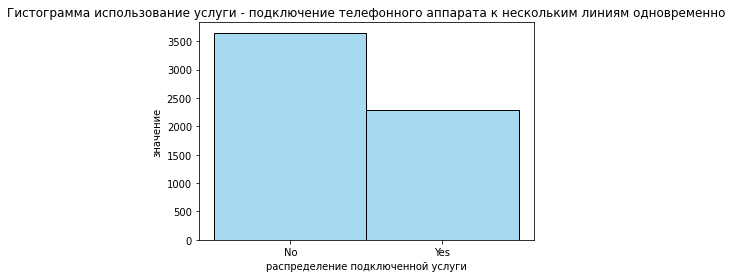

In [74]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 0], x='multipleLines', color='skyblue')  
plt.title('Гистограмма использование услуги - подключение телефонного аппарата к нескольким линиям одновременно')  
plt.xlabel('распределение подключенной услуги')  
plt.ylabel('значение')  
plt.show()  

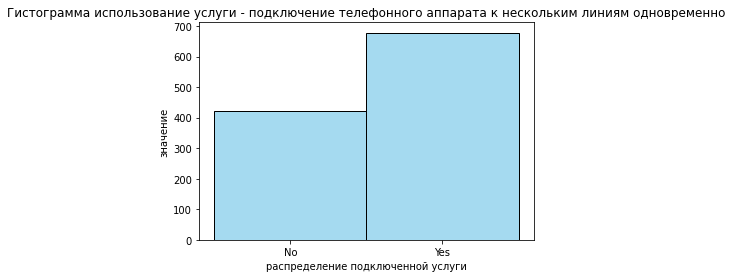

In [75]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df[df['target'] == 1], x='multipleLines', color='skyblue')  
plt.title('Гистограмма использование услуги - подключение телефонного аппарата к нескольким линиям одновременно')  
plt.xlabel('распределение подключенной услуги')  
plt.ylabel('значение')  
plt.show()  

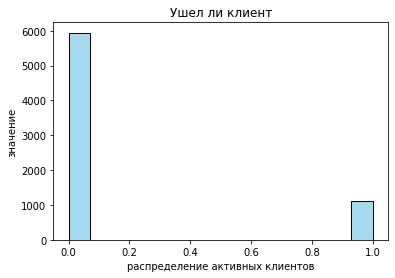

In [76]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=df, x='target', color='skyblue')  
plt.title('Ушел ли клиент')  
plt.xlabel('распределение активных клиентов')  
plt.ylabel('значение')  
plt.show()  

И самое важное - целевой признак. Большая часть клиентов пользуется сервисом, только не большая перестала его использовать

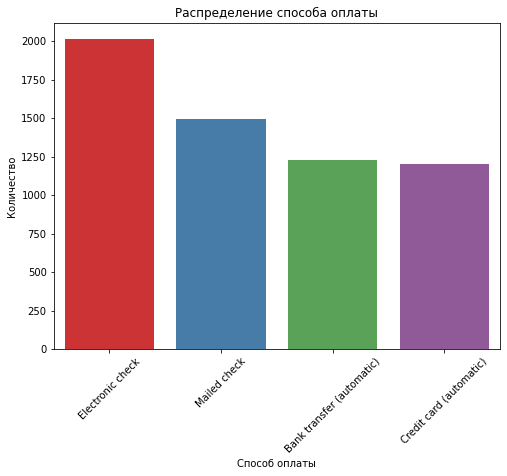

In [77]:
plt.figure(figsize=(8, 6))  
sns.countplot(data=df[df['target'] == 0], x='payment_method', palette='Set1')  
plt.title('Распределение способа оплаты')  
plt.xlabel('Способ оплаты')  
plt.ylabel('Количество') 
plt.xticks(rotation=45)  
plt.show() 

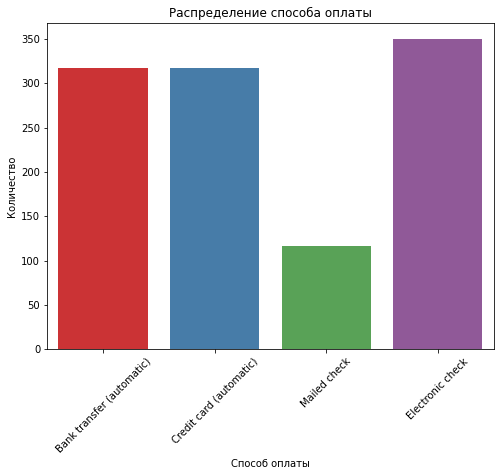

In [78]:
plt.figure(figsize=(8, 6))  
sns.countplot(data=df[df['target'] == 1], x='payment_method', palette='Set1')  
plt.title('Распределение способа оплаты')  
plt.xlabel('Способ оплаты')  
plt.ylabel('Количество') 
plt.xticks(rotation=45)  
plt.show() 

Ушедвшие клиенты не любили чек по почте

Электронному чеку отдаюют приоритет, остальное примерно в равных рамках

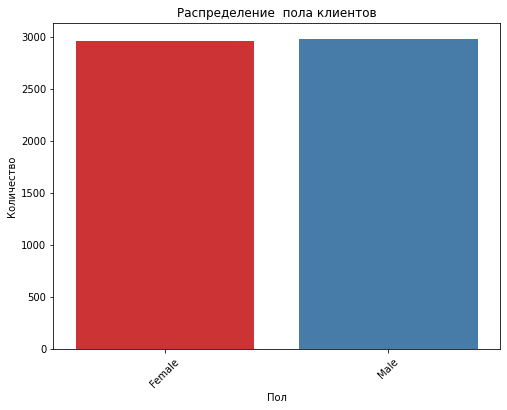

In [79]:
plt.figure(figsize=(8, 6))  
sns.countplot(data=df[df['target'] == 0], x='gender', palette='Set1')  
plt.title('Распределение  пола клиентов')  
plt.xlabel('Пол')  
plt.ylabel('Количество') 
plt.xticks(rotation=45)  
plt.show() 

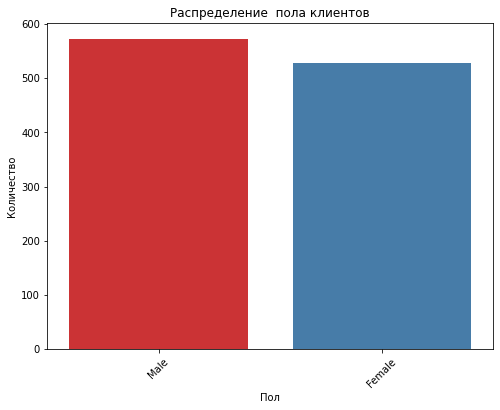

In [80]:
plt.figure(figsize=(8, 6))  
sns.countplot(data=df[df['target'] == 1], x='gender', palette='Set1')  
plt.title('Распределение  пола клиентов')  
plt.xlabel('Пол')  
plt.ylabel('Количество') 
plt.xticks(rotation=45)  
plt.show() 

Крит разичий нет

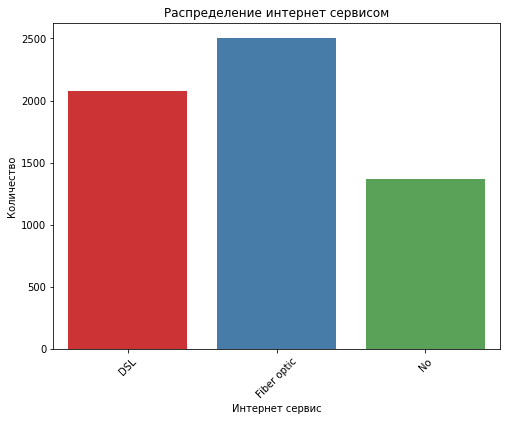

In [81]:
plt.figure(figsize=(8, 6))  
sns.countplot(data=df[df['target'] == 0], x='internet_service', palette='Set1')  
plt.title('Распределение интернет сервисом')  
plt.xlabel('Интернет сервис')  
plt.ylabel('Количество') 
plt.xticks(rotation=45)  
plt.show() 

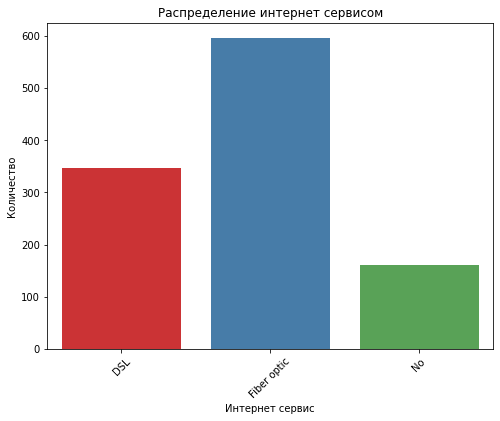

In [82]:
plt.figure(figsize=(8, 6))  
sns.countplot(data=df[df['target'] == 1], x='internet_service', palette='Set1')  
plt.title('Распределение интернет сервисом')  
plt.xlabel('Интернет сервис')  
plt.ylabel('Количество') 
plt.xticks(rotation=45)  
plt.show() 

У обоих классов идирует fiber optic, однако активные пользователи судя по всему больше любят DSL чем покинувшие

0 в данном случае возможный пропуск, ведь по заданию сказано, что сервис один из двух. в этом случае так и оставлю, будем иметь ввиду

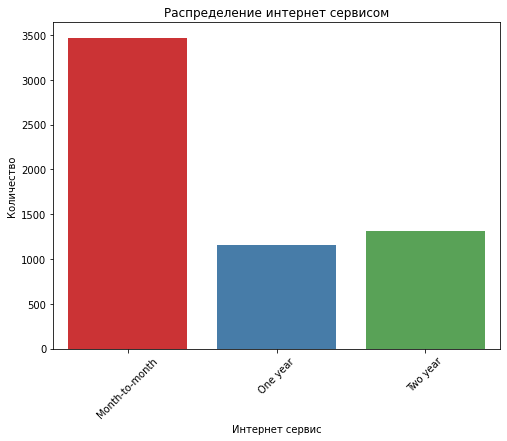

In [83]:
plt.figure(figsize=(8, 6))  
sns.countplot(data=df[df['target'] == 0], x='type', palette='Set1')  
plt.title('Распределение интернет сервисом')  
plt.xlabel('Интернет сервис')  
plt.ylabel('Количество') 
plt.xticks(rotation=45)  
plt.show() 

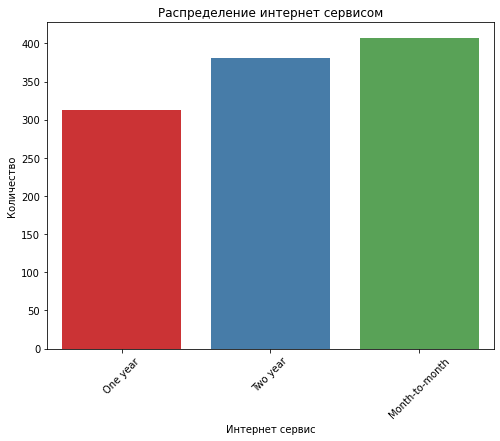

In [84]:
plt.figure(figsize=(8, 6))  
sns.countplot(data=df[df['target'] == 1], x='type', palette='Set1')  
plt.title('Распределение интернет сервисом')  
plt.xlabel('Интернет сервис')  
plt.ylabel('Количество') 
plt.xticks(rotation=45)  
plt.show() 

Видно, что ушедшие клиенты предпочитали брать тариф на 2 года, а текущие ежемесячную подписку

**Итог**

- Были замечаный выбросы (признак total_charges), были устранены
- Распределение клиентов
    - Пенсионеров меньше
    - Половой признак равен
    - Тоже самое касается партнеров
- Распределения услуг
    - Все услуги пользуются примрено равным спросом
- Целевой признак имеет дисбаланс, ушедших клиентов намного меньше, чем активных
- Используя услуги, пользователи предпочитают оплачивать помесячно 
- Предпочитаемый способ оплаты - цифровая абонентская линия
- Электронный чек пользуется спросом



**Различия классов**

- На мой взгляд самое весемое отличие это факт того, что клиенты отказывались от услуг, когда платил больше
- Новые и текущие клиенты предпочитают месячную подписку

In [85]:
numeric_columns = ['monthly_charges', 'total_days', 'total_charges']

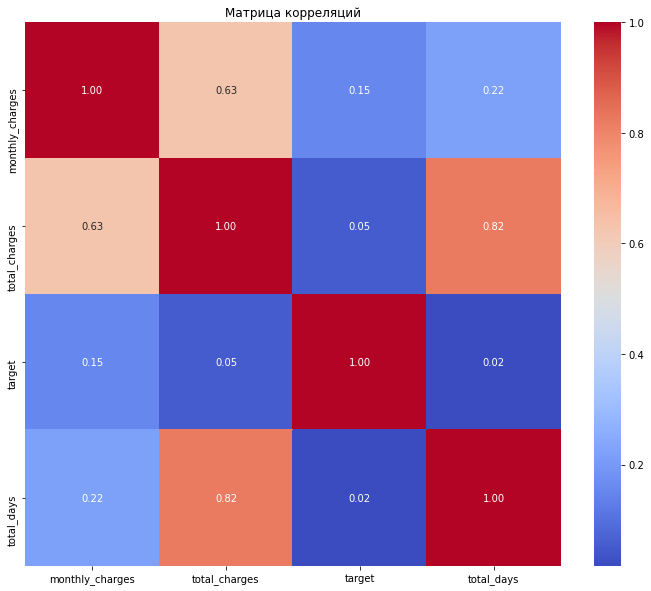

In [89]:

correlation_matrix = df.drop(columns=['senior_citizen']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций')
plt.show()


Можно удалить total_charges из-за мультиколинеарности

Теперь можно заняться подготовкой данных к обучению

In [90]:
del df['total_charges']

<h1>Подготовка данных</h1

Итак, начнем с удаления признаков

- ID клиента
- Даты

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   target             7043 non-null   int64         
 7   total_days         7043 non-null   int64         
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14

In [92]:
del df['begin_date'], df['end_date']

Теперь нужно все признаки привести к числовому значению. Нужно использовать энкодинг

**OHE**

Тут я буду использовать его, тк он не создатет порядковых зависимостей между значениями(котороым тут и не место), а создание доп признаков в данный момент не страшно, тк значений слишком мало, это не должно сказаться плохо на методе дерева или леса

Теперь разбиваю датасет на выборки для обучения

In [93]:
target = df['target'] 
features = df.drop(columns=['target'])

In [94]:
features

,type,paperless_billing,payment_method,monthly_charges,total_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streamingTV,streaming_movies,multipleLines
customer_id,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,One year,No,Mailed check,56.95,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,One year,Yes,Mailed check,84.80,730,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
2234-XADUH,One year,Yes,Credit card (automatic),103.20,2191,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,337,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,No


In [95]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)


In [96]:
features_train

,type,paperless_billing,payment_method,monthly_charges,total_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streamingTV,streaming_movies,multipleLines
customer_id,,,,,,,,,,,,,,,,,
2770-NSVDG,Month-to-month,No,Electronic check,29.10,730,Male,0,Yes,No,DSL,No,No,Yes,No,No,No,No
3018-TFTSU,Month-to-month,No,Bank transfer (automatic),81.70,488,Male,0,No,No,Fiber optic,Yes,No,Yes,No,No,No,No
3420-YJLQT,Month-to-month,No,Electronic check,79.55,62,Female,0,No,No,Fiber optic,No,Yes,No,No,No,No,Yes
5681-LLOEI,One year,Yes,Credit card (automatic),91.25,1310,Male,0,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,No,No,Yes
2235-DWLJU,Month-to-month,Yes,Electronic check,44.40,184,Female,1,No,No,DSL,No,No,No,No,Yes,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3146-MSEGF,Two year,Yes,Credit card (automatic),88.05,2191,Female,1,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes
0305-SQECB,One year,Yes,Mailed check,36.05,337,Female,0,No,Yes,DSL,Yes,No,No,Yes,No,No,No
6967-QIQRV,One year,No,Electronic check,101.90,457,Male,0,Yes,Yes,Fiber optic,Yes,No,No,Yes,Yes,Yes,No


In [97]:
features_train.columns.to_list()

['type',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'total_days',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streamingTV',
 'streaming_movies',
 'multipleLines']

In [98]:
categ = ['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streamingTV',
 'streaming_movies',
 'multipleLines']

In [99]:
numeric_columns = ['monthly_charges', 'total_days']

In [100]:
num_list = numeric_columns
test_features = features_test

In [101]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train[categ])
features_train[ encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[categ])
features_train = features_train.drop(categ, axis=1)
scaler = StandardScaler()
features_train[num_list] = scaler.fit_transform(features_train[num_list])
test_features[ encoder_ohe.get_feature_names_out() ] = encoder_ohe.transform(test_features[categ])
test_features = test_features.drop(categ, axis=1)

test_features[num_list] = scaler.transform( test_features[num_list] )



/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [102]:

display(features_train.head())
display(test_features.head())


,monthly_charges,total_days,senior_citizen,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streamingTV_Yes,streaming_movies_Yes,multipleLines_Yes
customer_id,,,,,,,,,,,,,,,,,,,,,
2770-NSVDG,-1.185252,-0.245278,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3018-TFTSU,0.556484,-0.599470,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3420-YJLQT,0.485291,-1.222965,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5681-LLOEI,0.872712,0.603611,0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
2235-DWLJU,-0.678625,-1.044405,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


,monthly_charges,total_days,senior_citizen,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streamingTV_Yes,streaming_movies_Yes,multipleLines_Yes
customer_id,,,,,,,,,,,,,,,,,,,,,
9917-KWRBE,0.445556,0.512868,0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
6217-KDYWC,-1.499824,1.228570,0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3996-ZNWYK,-1.493202,1.852064,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4835-YSJMR,-0.499816,0.423588,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9605-WGJVW,0.175686,-1.268336,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Итог**

- Разбил датасет на выборки
- Применилл масштабироварние
- Избавился от лишних признаков

<h1>Обучение моделей

**Линейная регрессия**

In [103]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], 
    'penalty': ['l1', 'l2'],  
    'max_iter': [100, 1000, 10000] 
}

logistic_regression = LogisticRegression(solver='liblinear')

grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='roc_auc')

grid_search.fit(features_train, target_train)

print("Наилучшие гиперпараметры:", grid_search.best_params_)


best_cv_score = grid_search.best_score_
print('ROC-AUC на кросс-валидации (лучшая модель):', best_cv_score)



Наилучшие гиперпараметры: {'C': 100, 'max_iter': 100, 'penalty': 'l2'}
ROC-AUC на кросс-валидации (лучшая модель): 0.7530563523543305


**Дерево решений**

In [104]:
decision_tree = DecisionTreeClassifier()

param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50]
    
}

grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='roc_auc')

grid_search.fit(features_train, target_train)

print("Наилучшие гиперпараметры:", grid_search.best_params_)

best_cv_score = grid_search.best_score_
print('ROC-AUC на кросс-валидации (лучшая модель):', best_cv_score)

Наилучшие гиперпараметры: {'max_depth': 10}
ROC-AUC на кросс-валидации (лучшая модель): 0.7313264085970564


**Случайный лес**

In [105]:
random_forest = RandomForestClassifier(class_weight='balanced')

param_grid = {
    'n_estimators': [5, 10, 20],
    'max_depth': [None, 10, 20, 30, 40, 50]
    
}

grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='roc_auc')

grid_search.fit(features_train, target_train)

print("Наилучшие гиперпараметры:", grid_search.best_params_)

best_cv_score = grid_search.best_score_
print('ROC-AUC на кросс-валидации (лучшая модель):', best_cv_score)

Наилучшие гиперпараметры: {'max_depth': 10, 'n_estimators': 20}
ROC-AUC на кросс-валидации (лучшая модель): 0.7984048139354133


**CatBoostClassifier**

In [106]:
param_grid = {
    'learning_rate': [0.1, 0.3, 0.5],
    'iterations': [25, 50, 100],
    'l2_leaf_reg': [3, 6, 9]
}
model = CatBoostClassifier(random_state=12345, verbose=0)


search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)


print(search.best_params_)


best_model = search.best_estimator_

{'iterations': 100, 'l2_leaf_reg': 6, 'learning_rate': 0.5}


In [107]:
best_cv_score = search.best_score_
print('ROC-AUC на кросс-валидации (лучшая модель):', best_cv_score)

ROC-AUC на кросс-валидации (лучшая модель): 0.8953873018148373


**Тестирование модели**

Лучший и единственный приемлемый результат получлся у CatBoostClassifier. 

In [108]:
best_model = search.best_estimator_ 
roc_auc_scores = best_model.predict_proba(test_features)[:, 1]
print('ROC-AUC на тестовых данных (лучшая модель):', roc_auc_score(target_test, roc_auc_scores))

ROC-AUC на тестовых данных (лучшая модель): 0.8964676263727998


 Визуализация ROC-кривой

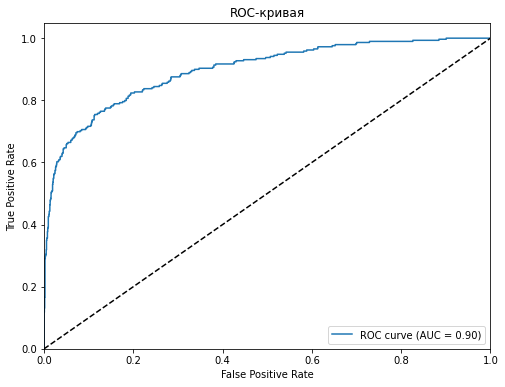

In [109]:
roc_auc_scores = best_model.predict_proba(test_features)[:, 1]


fpr, tpr, thresholds = roc_curve(target_test, roc_auc_scores)

roc_auc = roc_auc_score(target_test, roc_auc_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Рассмотрим accuracy и матрицу ошибок

Accuracy на тестовых данных (лучшая модель): 0.9045996592844975


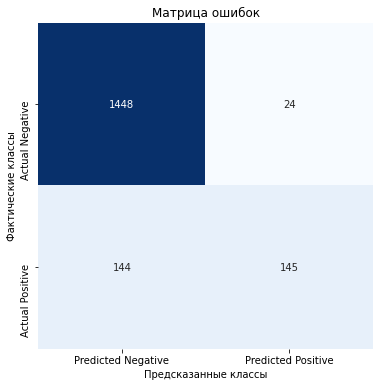

In [110]:
predictions = best_model.predict(test_features)


accuracy = accuracy_score(target_test, predictions)
print('Accuracy на тестовых данных (лучшая модель):', accuracy)


conf_matrix = confusion_matrix(target_test, predictions)


plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Предсказанные классы')
plt.ylabel('Фактические классы')
plt.title('Матрица ошибок')
plt.show()

Важность признаков

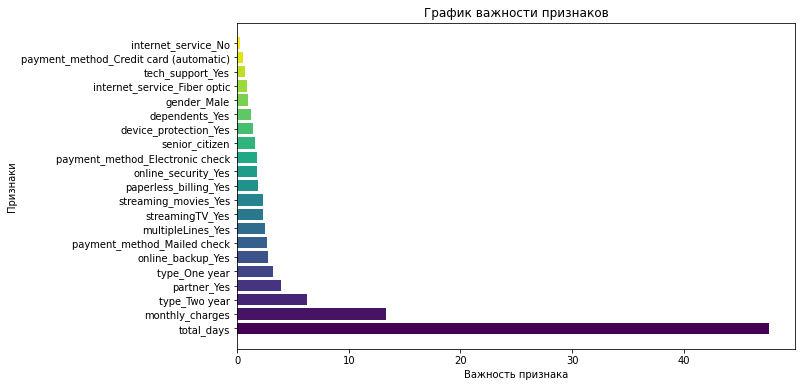

In [111]:
feature_importance = best_model.get_feature_importance()
feature_names = test_features.columns


sorted_indices = feature_importance.argsort()[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_feature_names)))

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importance, color=colors)
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('График важности признаков')
plt.show()

**Итог**

- Была сделана предобработка данных
    - Переименование столбцов
    - Изменение типов данных
    - Был добавлен новый целевой признак, который отображает активен ли клиент
    - Заполнены пропуски
    - Дубликатов не обнаружено
    
- Был сделан исследовательский анализ данных:
    - Устранены выбросы
    - Построены графики для визуализации распредления

- Была проведена подготвка данных к обучению:
    - Удалены ненужные столбцы
    - Примененил энкодинг
    - Применено масштабирование
    - Датасет был разделен на обучающую и тестовую выборку
    - Сбалансировал классы
    
- Были обучены модели
    - По итогу хороший результат получила последняя модель CatBoostClassifier со значением 0.89
    

**Отчет по проекту**

**Какие пункты плана были выполнены**

- Загрузка данных
    - Поиск дубликатов
    - Поиск пропусков
    - Замена типов данных
    - Переименование столбцов 
    

     
- EDA 
    - Поиск выбросов и принятие решения что с ними делать
    - Визуализация распределения признаков
    - Объеденение таблиц
    - Создание нового целевого признака
    - Просмотр корреляции




- Подготовка данных к обучению
    - Отдельить целевой признак от остальных
    - Раздеение данных на выборки
    - Применение OHE
    - Применение масштабирование




- Обучение моделей
    - Обучить несколько моделей с подбором гиперпараметров
    - Рассмотреть результаты на трейн выборке
    - Выбрать лучшую модель с показателем ROC-AUC > 0.85
    



- Тестирование модели
    - Протетсировать модель
    - Рассмотреть матрицу признаков
    - Визуализация ROC-кривой
    - Просмотр метрики accuracy
    - Выявление наиболее важных признаков



**Ключевые шаги в решении задачи**


- Загрузка данных
- EDA
- Подготовка данных к обучению
- Обучение модели
- Тестирование модели
- Визуализация выводов
- Итоговый отчет


**Какие признаки использовал для обучения модели и какая предобработка этих признаков была выполнена?**



   type                 
   paperless_billing       
   payment_method                              
   total_days               
   gender                 
   senior_citizen         
   partner                   
   dependents                
   internet_service        
   online_security          
   online_backup            
   device_protection       
   tech_support            
   streamingTV              
   streaming_movies      
   multipleLines


   Применил OneHoteEncoder и StandertScaler



   **итоговая модель, какие у неё гиперпараметы и какое качество**  

   - Лучшее качество показала CatBoost с гипермапараметрами  {'iterations': 100, 'l2_leaf_reg': 6, 'learning_rate': 0.5}

   - Результат  0.8953873018148373 > 0.85(по ТЗ)
   - Использовал RANDOMSTATE=161023
   - ROC кривая
   
  
   
          

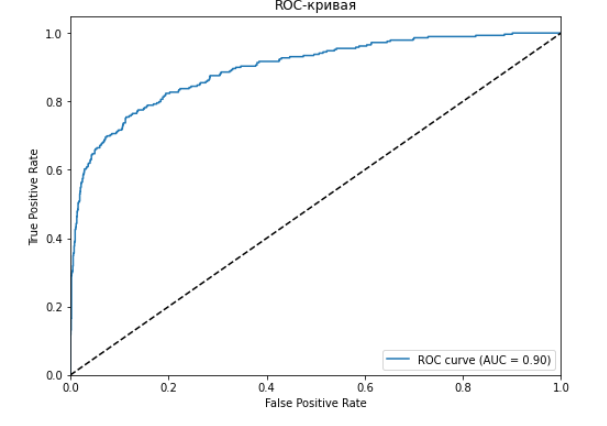

Матрица ошибок

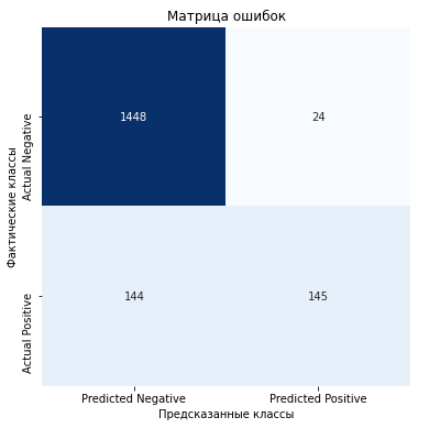

Важность признаков 

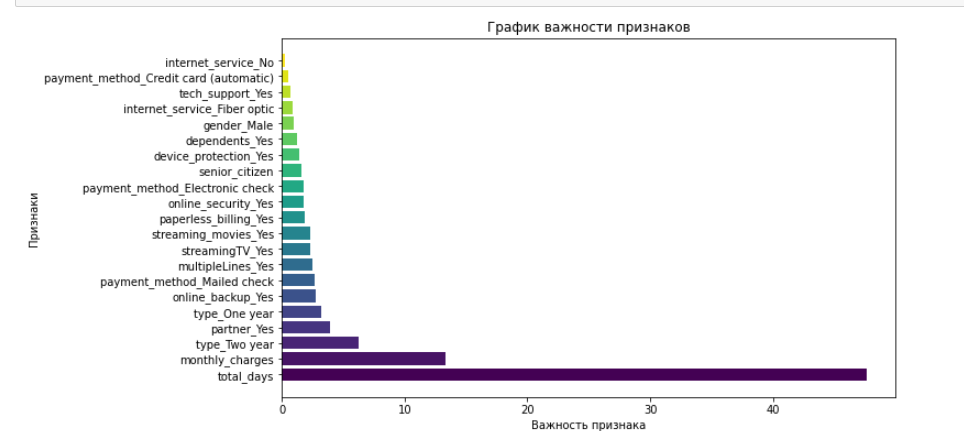